In [1]:
# import matplotlib
# matplotlib.use('Agg')

import numpy as np
import os, glob
import datetime
from netCDF4 import Dataset
from collections import namedtuple
from data import anomaly,global_average
from scipy import stats

In [2]:
def colorplotLeft(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

In [3]:
## ceres data; from fig. 1 file
## based on regression up to 1/17
ceresR=-0.17

In [4]:
modelRun = namedtuple('modelRun', ('t', 'ts','t_trop','ts_trop','flux'))
modelType = namedtuple('modelType', ('piControl','abrupt4xCO2'))

def readFile(modx,runx):
	"""read global and tropical avg. nc file"""
	fni=Dataset('cmip5/{0}.{1}.nc'.format(mn,runx))
	ovar=[]
	for ii in ['flux','ta','tas','t_trop','tas_trop']:
		ovar.append(anomaly(fni[ii][:].squeeze()))
	modout=modelRun(flux=ovar[0],t=ovar[1],ts=ovar[2],t_trop=ovar[3],ts_trop=ovar[4])
	return modout

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()

In [5]:
skip=16*12;length=16

feedbacks={};modelOutput={}
for mn in models:
	piC=readFile(mn,'piControl')	
	abrupt=readFile(mn,'abrupt4xCO2')
	feedbacks[mn]=modelType(piControl=piC,abrupt4xCO2=abrupt)
	print('{} '.format(mn),end="")
	sys.stdout.flush()

	## analyze the run
	m1all=[];abrupt=[]
	for latr,varn in zip(['90','30'],['ts','t']):
		
		mod1=feedbacks[mn].piControl # control run
		s=len(mod1.t)

		tvar=varn
		if latr == '30': tvar = tvar+'_trop'
		commandStr='tg=mod1.{}'.format(tvar)
		exec(commandStr)

		# flux is the same for all calcs
		flux=mod1.flux
		
		m1=[]
		for ii in range(0,s-length*12,skip):
			indx=range(ii,ii+length*12)
			fitx=stats.linregress(anomaly(tg[indx]),anomaly(flux[indx]))
			m1.append(fitx[2])

		m1all.append(m1)

	modelOutput[mn]=modelType(piControl=m1all,abrupt4xCO2=[0])

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CSIRO-Mk3-6-0 

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 

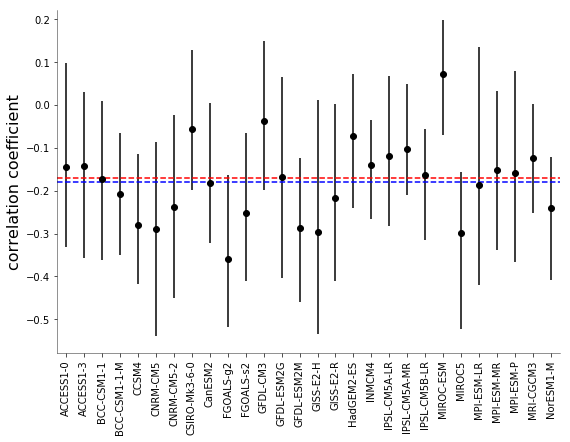

In [6]:
figure(figsize=(9,7))
plt.subplots_adjust(bottom=0.2)
values1=np.array([np.average(modelOutput[ii].piControl[0]) for ii in models])
values2=np.array([np.max(modelOutput[ii].piControl[0]) for ii in models])
values3=np.array([np.min(modelOutput[ii].piControl[0]) for ii in models])
errorbar(np.arange(len(values1)),values1,yerr=[values1-values3,values2-values1],fmt='o',color='k')
ylim(np.average(values1)-0.4,np.average(values1)+0.4)#;grid()
ylabel('correlation coefficient',fontsize=16)
axhline(ceresR,color='r',ls='dashed') # from Fig. 1 file
axhline(np.average(values1),color='b',ls='dashed')
gca().set_xticks(range(len(models)));
gca().set_xticklabels(models,rotation='90');
xlim(-0.5,len(models)-0.5)
colorplotLeft(gca())
# savefig('fig4.eps')

(-0.5, 27.5)

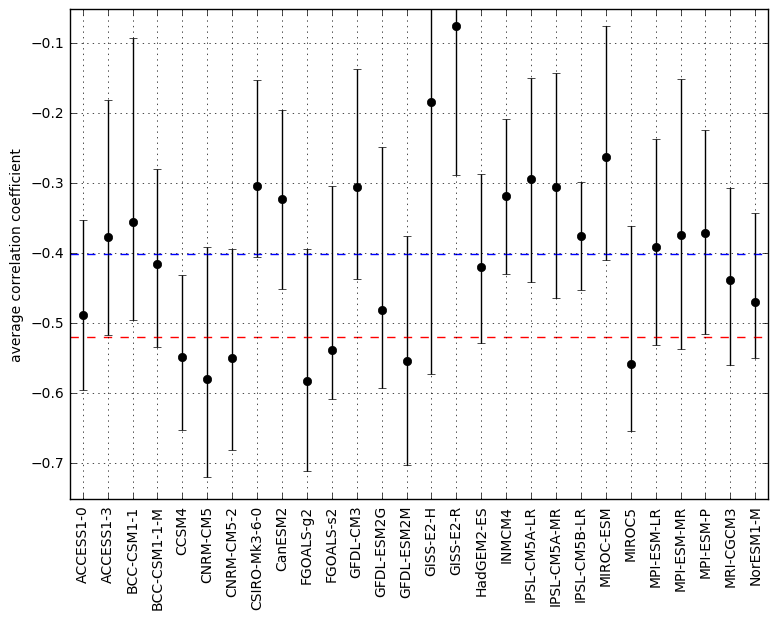

In [5]:
figure(figsize=(9,7))
plt.subplots_adjust(bottom=0.2)
values1=np.array([np.average(modelOutput[ii].piControl[1]) for ii in models])
values2=np.array([np.max(modelOutput[ii].piControl[1]) for ii in models])
values3=np.array([np.min(modelOutput[ii].piControl[1]) for ii in models])
errorbar(np.arange(len(values1)),values1,yerr=[values1-values3,values2-values1],fmt='o',color='k')
ylim(np.average(values1)-0.35,np.average(values1)+0.35);grid()
ylabel('average correlation coefficient')
axhline(-0.52,color='r',ls='dashed') # from Fig. 1 file
axhline(np.average(values1),color='b',ls='dashed')
gca().set_xticks(range(len(models)));
gca().set_xticklabels(models,rotation='90');
xlim(-0.5,len(models)-0.5)

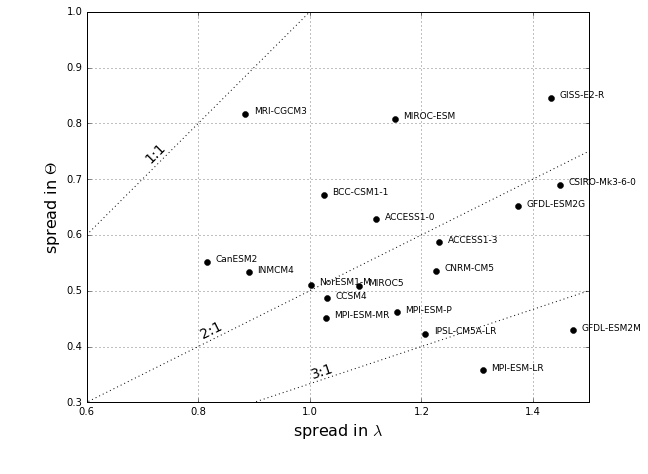

In [4]:
# summary plots
# plot showing that variability in control runs vs. Ts is greater than vs. T500,tropics
figure(figsize=(9,7))
values1=[[np.percentile(modelOutput[ii].piControl[jj],95)-\
	np.percentile(modelOutput[ii].piControl[jj],5) for ii in models] for jj in [0,1]]
plot(values1[0],values1[1],'ko')
xlim(0.6,1.5);ylim(0.3,1);grid()
xlabel('spread in $\lambda$',fontsize=16)
ylabel('spread in $\Theta$',fontsize=16)
for ii in range(len(models)):
	annotate(models[ii], (values1[0][ii]+0.015,values1[1][ii]),fontsize=9)
plot(np.linspace(0,1.8),np.linspace(0,1.8),'k',ls='dotted')
plot(np.linspace(0,1.8),np.linspace(0,1.8)/2,'k',ls='dotted')
plot(np.linspace(0,1.8),np.linspace(0,1.8)/3,'k',ls='dotted')
annotate('1:1',(0.7,0.75),fontsize=14,rotation=45)
annotate('2:1',(0.8,0.43),fontsize=14,rotation=26.5)
annotate('3:1',(1,0.355),fontsize=14,rotation=18.4)
# plot([1.158],[0.416],'ro',markersize=10) # values calculated in fig3.py
savefig('spread.eps')

### make plots for one model

In [15]:
mn='CCSM4' # model to plot up
p1,p2=[modelOutput[mn].piControl[ii] for ii in [0,1]]

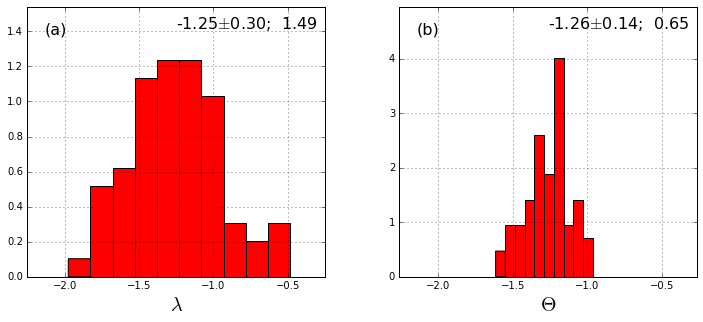

In [17]:
# figure 4 — histogram version
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plt.subplots_adjust(bottom=0.15,wspace=0.25,top=0.9)
# plt.suptitle('global avg. surface T',fontsize=20)

for m1,ax,labx,xlabx in zip([p1,p2],axes.reshape(2),'a,b'.split(','),['$\lambda$','$\Theta$']):
    # for jj in m1all: ax.plot(jj,'0.6')
    ax.grid()
    ax.hist(m1,color='r',normed=True)

    ax.text(0.5,0.92,'%5.2f$\pm$%4.2f; %5.2f' % (np.average(m1),np.std(m1),np.max(m1)-np.min(m1)),\
            fontsize=16,transform=ax.transAxes)
    ax.text(0.06,0.9,'({})'.format(labx),fontsize=16,transform=ax.transAxes)

    ax.set_xlim(np.average(m1)-1,np.average(m1)+1)
    x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.1)
    
    ax.set_xlabel(xlabx,fontsize=20)
# savefig('pdfs.jpg')

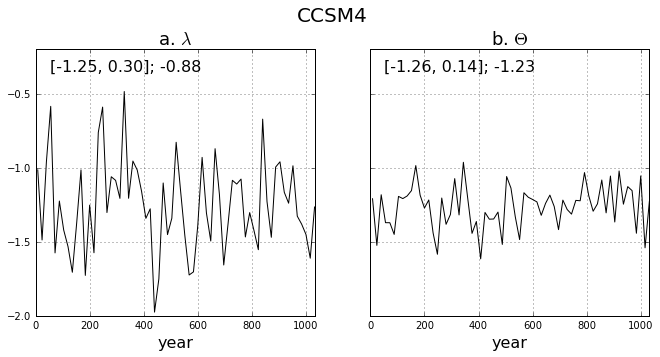

In [14]:
m1time=np.arange(len(modelOutput[mn].piControl[0]))*skip/12.+length/2

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(11,5))
plt.subplots_adjust(top=0.86,bottom=0.12)
plt.suptitle(mn,fontsize=20)

for ax,ii,labx,abruptx in zip(axes.flatten(),modelOutput[mn].piControl,\
    ['a. $\lambda$','b. $\Theta$'],\
    modelOutput[mn].abrupt4xCO2): 
    ax.plot(m1time,ii,'k')
    ax.set_title(labx,fontsize=18)
    ax.grid()
    ax.text(0.05, 0.92,'[%5.2f,%5.2f]; %5.2f' % (np.average(ii),np.std(ii),abruptx[1]), \
        transform=ax.transAxes, fontsize=16)
#     ax.axhline(abruptx[0], color='r',ls='--')
#     ax.axhline(abruptx[1], color='b',ls='--')
    ax.set_xlim(0,np.max([np.max(m1time),500]))
    ax1=ax.get_ylim();ax.set_ylim(ax1[0],ax1[1]+0.1)
    ax.set_xlabel('year',fontsize=16)
# savefig(mn)